<a href="https://colab.research.google.com/github/solislemuslab/colonization-squid/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
data_path = '/content/gdrive/My Drive/squid/'
squid = pd.read_excel(data_path+'Dataset-S1.xlsx')
squid.shape

(3983, 31)

In [ ]:
SEED = 100
categories = [1,2,3,4,5,6]

In [ ]:
X, Y = squid.drop(['Category'], axis=1), squid.Category
xtrain_full, xtest, ytrain_full, ytest = \
  train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)
xtrain, xval, ytrain, yval = \
  train_test_split(xtrain_full, ytrain_full, test_size=0.15, random_state=SEED, stratify=ytrain_full)
print(f'Shape: Training {xtrain.shape[0]}, Validation {xval.shape[0]}, Test {xtest.shape[0]}')

Shape: Training 2708, Validation 478, Test 797


In [ ]:
def getMetrics(label, pred):
  acc = accuracy_score(label, pred)
  # recall = recall_score(label, pred)
  f1 = f1_score(label, pred, average="weighted")
  confusion_mat = pd.DataFrame(confusion_matrix(label, pred), columns=categories, index=categories)

  print(f'Prediction Result:\nacc:{np.round(acc*100, 3)}%, f1 score:{np.round(f1,4)}.')
  print(confusion_mat)
  return acc, f1, confusion_matrix

# Dummy Classifier

In [ ]:
dummy_clf = DummyClassifier(strategy='most_frequent').fit(xtrain, ytrain)
dummy_pred_train = dummy_clf.predict(xtrain)
dummy_pred_val = dummy_clf.predict(xval)
dummy_pred_test = dummy_clf.predict(xtest)

In [ ]:
_, _, dummy_confusion_train = getMetrics(ytrain, dummy_pred_train)

Prediction Result:
acc:48.006%, f1 score:0.3114.
   1  2  3  4     5  6
1  0  0  0  0   106  0
2  0  0  0  0   309  0
3  0  0  0  0    78  0
4  0  0  0  0   657  0
5  0  0  0  0  1300  0
6  0  0  0  0   258  0


In [ ]:
_, _, dummy_confusion_val = getMetrics(yval, dummy_pred_val)

Prediction Result:
acc:47.908%, f1 score:0.3104.
   1  2  3  4    5  6
1  0  0  0  0   18  0
2  0  0  0  0   55  0
3  0  0  0  0   14  0
4  0  0  0  0  116  0
5  0  0  0  0  229  0
6  0  0  0  0   46  0


In [ ]:
_, _, dummy_confusion_test = getMetrics(ytest, dummy_pred_test)

Prediction Result:
acc:47.93%, f1 score:0.3106.
   1  2  3  4    5  6
1  0  0  0  0   31  0
2  0  0  0  0   91  0
3  0  0  0  0   23  0
4  0  0  0  0  194  0
5  0  0  0  0  382  0
6  0  0  0  0   76  0


# Baseline

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
drop_list = ['ID','Chromosome','Coordinate','Locus_Tag','Gene','Annotation']
xtrain_nums = xtrain.drop(drop_list, axis=1)
xval_nums = xval.drop(drop_list, axis=1)
xtest_nums = xtest.drop(drop_list, axis=1)

In [ ]:
rf_clf = RandomForestClassifier(random_state=SEED).fit(xtrain_nums, ytrain)
rf_pred_train = rf_clf.predict(xtrain_nums)
rf_pred_val = rf_clf.predict(xval_nums)
rf_pred_test = rf_clf.predict(xtest_nums)

In [ ]:
_, _, rf_confusion_train = getMetrics(ytrain, rf_pred_train)

Prediction Result:
acc:97.637%, f1 score:0.9779.
     1    2   3    4     5    6
1  106    0   0    0     0    0
2   56  253   0    0     0    0
3    0    1  77    0     0    0
4    6    1   0  650     0    0
5    0    0   0    0  1300    0
6    0    0   0    0     0  258


In [ ]:
_, _, rf_confusion_val = getMetrics(yval, rf_pred_val)

Prediction Result:
acc:88.703%, f1 score:0.8849.
    1   2   3    4    5   6
1  15   1   1    1    0   0
2   9  39   4    2    1   0
3   0   2  10    2    0   0
4   1   2   3  108    1   1
5   0   0   0    4  224   1
6   0   0   0    3   15  28


In [ ]:
_, _, _ = getMetrics(ytest, rf_pred_test)

Prediction Result:
acc:91.217%, f1 score:0.9108.
    1   2   3    4    5   6
1  27   0   1    2    1   0
2  11  72   3    3    1   1
3   0   5  12    6    0   0
4   6   6   1  180    0   1
5   0   0   0    2  379   1
6   0   0   0    2   17  57


In [ ]:
def plot_var_importance(model, features, figsize=(8,6), c='b', title="Relative Importance"):
  fig, ax = plt.subplots(1,1,figsize=figsize)
  imp = model.feature_importances_
  indices = np.argsort(imp)
  ax.barh([features[i] for i in indices], imp[indices], color=c, align='center')
  ax.set_yticks(range(len(indices)), [features[i] for i in indices])
  ax.set_title(title)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


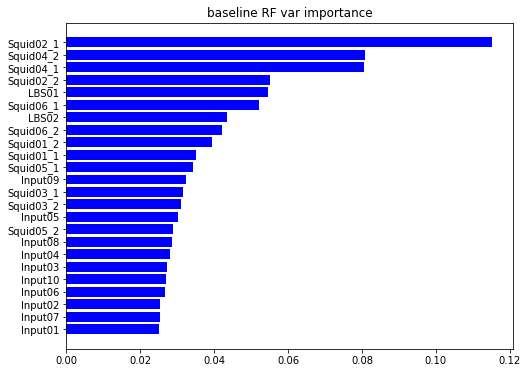

In [ ]:
plot_var_importance(rf_clf, xtrain_nums.columns, title='baseline RF var importance')

# Feature Selection

In [ ]:
retain_list = ['Input09','LBS01','Squid01_1','Squid02_1','Squid03_1','Squid04_1','Squid05_1','Squid06_1']
xtrain_min_selected = xtrain[retain_list].copy()
xval_min_selected = xval[retain_list].copy()
xtest_min_selected = xtest[retain_list].copy()

In [ ]:
rf_min_selected = RandomForestClassifier(random_state=SEED).fit(xtrain_min_selected, ytrain)
rf_min_selected_pred_train = rf_min_selected.predict(xtrain_min_selected)
rf_min_selected_pred_val = rf_min_selected.predict(xval_min_selected)
rf_min_selected_pred_test = rf_min_selected.predict(xtest_min_selected)

In [ ]:
_, _, rf_min_selected_confusion_train = getMetrics(ytrain, rf_min_selected_pred_train)

Prediction Result:
acc:95.495%, f1 score:0.941.
   1    2   3    4     5    6
1  4  102   0    0     0    0
2  0  308   1    0     0    0
3  0    9  69    0     0    0
4  0   10   0  647     0    0
5  0    0   0    0  1300    0
6  0    0   0    0     0  258


In [ ]:
_, _, rf_min_selected_confusion_train = getMetrics(yval, rf_min_selected_pred_val)

Prediction Result:
acc:87.029%, f1 score:0.8553.
   1   2  3    4    5   6
1  0  16  1    1    0   0
2  0  45  7    2    0   1
3  1   2  9    2    0   0
4  0   2  2  111    1   0
5  0   0  0    6  221   2
6  0   0  0    4   12  30


In [ ]:
_, _, rf_min_selected_confusion_train = getMetrics(ytest, rf_min_selected_pred_test)

Prediction Result:
acc:87.829%, f1 score:0.8615.
   1   2   3    4    5   6
1  0  28   0    2    1   0
2  0  79   5    5    1   1
3  0   4  10    9    0   0
4  0  11   3  178    2   0
5  0   0   0    6  375   1
6  0   0   0    1   17  58


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


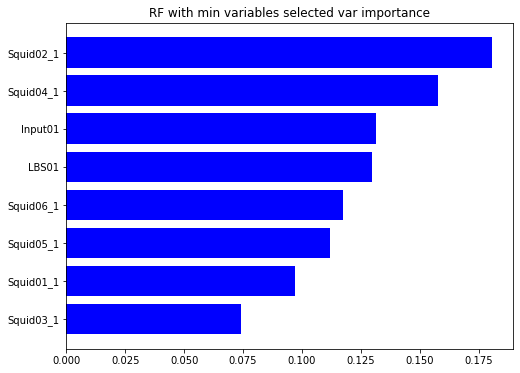

In [ ]:
plot_var_importance(rf_min_selected, xtrain_min_selected.columns, title='RF with min variables selected var importance')

In [ ]:
def get_avg(df):
  df['input_avg'] = df[input_col_list].mean(axis=1)
  df['lbs_avg'] = df[lbs_col_list].mean(axis=1)

def get_col_list(start=1, stop=11, verbal=False):
  res = []
  for i in range(start,stop):
    s = 'Input' 
    if i < 10:
      s += '0'
    s += str(i)
    res.append(s)
  if verbal:
    print(res)
  return res

input_col_list = get_col_list(verbal=False)
lbs_col_list = get_col_list(1,2)
get_avg(xtrain)
get_avg(xval)
get_avg(xtest)
agg_list = ['input_avg','lbs_avg','Squid01_1','Squid02_1','Squid03_1','Squid04_1','Squid05_1','Squid06_1']
xtrain_input_avg = xtrain[agg_list].copy()
xval_input_avg = xval[agg_list].copy()
xtest_input_avg = xtest[agg_list].copy()

In [ ]:
rf_input_avg = RandomForestClassifier(random_state=SEED).fit(xtrain_input_avg, ytrain)
rf_input_avg_pred_train = rf_input_avg.predict(xtrain_input_avg)
rf_input_avg_pred_val = rf_input_avg.predict(xval_input_avg)
rf_input_avg_pred_test = rf_input_avg.predict(xtest_input_avg)

In [ ]:
_, _, _ = getMetrics(ytrain, rf_input_avg_pred_train)

Prediction Result:
acc:97.046%, f1 score:0.9727.
     1    2   3    4     5    6
1  106    0   0    0     0    0
2   72  237   0    0     0    0
3    0    1  77    0     0    0
4    7    0   0  650     0    0
5    0    0   0    0  1300    0
6    0    0   0    0     0  258


In [ ]:
_, _, _ = getMetrics(yval, rf_input_avg_pred_val)

Prediction Result:
acc:87.657%, f1 score:0.8741.
    1   2  3    4    5   6
1  15   1  0    1    0   1
2  12  36  2    4    0   1
3   0   2  6    6    0   0
4   2   0  4  109    1   0
5   0   0  0    5  223   1
6   0   0  0    3   13  30


In [ ]:
_, _, _ = getMetrics(ytest, rf_input_avg_pred_test)

Prediction Result:
acc:88.708%, f1 score:0.8856.
    1   2  3    4    5   6
1  27   1  1    1    1   0
2  19  59  1   10    1   1
3   0   4  9   10    0   0
4   6   4  6  177    1   0
5   0   0  0    6  376   0
6   0   0  0    1   16  59


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


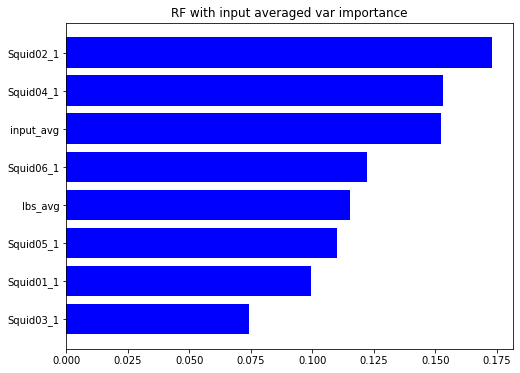

In [ ]:
plot_var_importance(rf_input_avg, xtrain_input_avg.columns, title='RF with input averaged var importance')